Statistics coded: Tourism Statistics

Prepared by Sarah Hadj Hassen.

In [ ]:
#install.packages(c("ggplot2", "plotly", "tidyr", "repr", "dplyr", "devtools", "restatapi"))
#install.packages("eurostat")
#install.packages("patchwork")
#install.packages("Matching")

library(ggplot2)
library(tidyr)
library(dplyr)
library(eurostat)
library(Matching)
library(stats)

In [ ]:
# create first graph
## tourism destinations - nights spent at toursit accommondation establishments, 2018

data <- get_eurostat(id="tour_occ_ninat")
nrow(data)

# first check whether all countries needed and create countries vector
countr <- c("ES","IT","FR","EL","AT","DE","HR","PT","NL","CZ","BE","BG","PL","IE","CY","SE","HU","DK","SI",
                         "MT","FI","SK","RO","EE","LV","LT","LU","UK","CH","NO","IS","LI","TR","ME","RS","MK","XK")
levels(data$geo)
levels(data$c_resid)
levels(data$nace_r2)

In [ ]:
# for Ireland, Slovenia, United Kingdom, Switzerland, Norway, Iceland, Montenegro, Serbia and Kosovo we need 2018 monthly data
data_month <- get_eurostat(id="tour_occ_nim")
nrow(data_month)

data_month$year <- as.integer(substr(data_month$time,1,4))
data_month$month <- as.integer(substr(data_month$time,6,7))

countr2 <- c("IE","SI","UK","CH","NO","IS","ME","RS","XK")

data_mod <- subset(data_month, 
                    data_month$geo %in% countr2 & 
                    data_month$year==2018 &
                    data_month$c_resid=="FOR" &
                    data_month$nace_r2=="I551-I553"&
                    data_month$unit=="NR")

nrow(data_mod)
levels(data_mod$geo)

data_mod1 <- aggregate(data_mod$values, by = list(geo = data_mod$geo), FUN = sum)
names(data_mod1)[2] <- "values"

In [ ]:
# building needed subset for the other countries
data$year <- as.integer(substr(data$time,1,4))
head(data)

data_mod2 <- subset(data, 
                    data$geo %in% countr & 
                    data$year==2018 &
                    data$c_resid=="FOR" &
                    data$nace_r2=="I551-I553"&
                    data$unit=="NR")
nrow(data_mod2)
data_mod2 <- data_mod2[,c(4,6)]
data_mod2

In [ ]:
# for Turkey we need data from 2016
countr3 <- c("TR")

data_mod3 <- subset(data, 
                    data$geo %in% countr3 & 
                    data$year==2016 &
                    data$c_resid=="FOR" &
                    data$nace_r2=="I551-I553"&
                    data$unit=="NR")
data_mod3 <- data_mod3[,c(4,6)]
data_mod3  

In [ ]:
#match data_mod1 and data_mod2 and data_mod3
data_mod4 <- rbind(data_mod1,data_mod2,data_mod3)
data_mod4

In [ ]:
# bring the country names in the order the grpahik shows
data_mod4$geo <- factor(data_mod4$geo,
                        levels = c("ES","IT","FR","EL","AT","DE","HR","PT","NL","CZ","BE","BG","PL","IE","CY","SE","HU",
                                   "DK","SI", "MT","FI","SK","RO","EE","LV","LT","LU","UK","CH","NO","IS","LI","TR","ME",
                                   "RS","MK","XK"))
data_mod4

In [ ]:
options(scipen=999)
ggplot(data_mod4, aes(x=geo,y=values)) +
            geom_bar(stat = "identity", position="dodge", width=0.5, fill="steelblue3") +
            theme_classic() +
            scale_y_continuous(limits = c(0, 310000000), breaks = seq(0, 300000000, by = 50000000)) +
            ggtitle("Tourism destinations - nights spent at tourist accomodation establishments, 2018")

In [ ]:
# create first table 
## tourist accomodation establishments, 2018

# we need 3 datasets for each column

In [ ]:
# column 1: number of establishments (units)
data_1 <- get_eurostat(id="tour_cap_nat")

data_1$year <- as.integer(substr(data_1$time,1,4))

# first check whether all countries needed and create countries vector
countr_1 <- c("BE","BG","CZ","DK","DE","EE","IE","EL","ES","FR","HR","IT","CY","LV","LT","LU","HU","MT","NL",
                         "AT","PL","PT","RO","SI","SK","FI","SE","UK","IS","LI","NO","CH","ME","MK","RS","TR","XK")

levels(data_1$geo)
levels(data_1$nace_r2)
levels(data_1$unit)
levels(data_1$accommod)

data_tab1 <- subset(data_1, 
                    data_1$geo %in% countr_1 & 
                    data_1$year==2018 &
                    data_1$nace_r2=="I551-I553"&
                    data_1$unit=="NR"&
                    data_1$accommod=="ESTBL")
data_tab1 <- data_tab1[,c(4,6)]

# for Ireland and United Kingdom we need data from 2016
countr_1_1 <- c("IE","UK")
data_tab1_1 <- subset(data_1, 
                      data_1$geo %in% countr_1_1 & 
                      data_1$year==2016 &
                      data_1$nace_r2=="I551-I553"&
                      data_1$unit=="NR"&
                      data_1$accommod=="ESTBL")
data_tab1_1 <- data_tab1_1[,c(4,6)]

# for Luxembourg, Slovenia and Kosovo we need data from 2017
countr_1_2 <- c("LU","SI","XK")
data_tab1_2 <- subset(data_1, 
                      data_1$geo %in% countr_1_2 & 
                      data_1$year==2017 &
                      data_1$nace_r2=="I551-I553"&
                      data_1$unit=="NR"&
                      data_1$accommod=="ESTBL")
data_tab1_2 <- data_tab1_2[,c(4,6)]

#matching
data_tab_col1 <- rbind(data_tab1,data_tab1_1,data_tab1_2)

# bring the country names in the order the grpahik shows
data_tab_col1 <- data_tab_col1[order(factor(data_tab_col1$geo, levels= countr_1)),]
data_tab_col1

In [ ]:
# column 2: number of bed places (thousands)
data_tab2 <- subset(data_1, 
                    data_1$geo %in% countr_1 & 
                    data_1$year==2018 &
                    data_1$nace_r2=="I551-I553"&
                    data_1$unit=="NR"&
                    data_1$accommod=="BEDPL")
data_tab2 <- data_tab2[,c(4,6)]

# for Ireland and United Kingdom we need data from 2016
countr_2_1 <- c("IE","UK")
data_tab2_1 <- subset(data_1, 
                      data_1$geo %in% countr_2_1 & 
                      data_1$year==2016 &
                      data_1$nace_r2=="I551-I553"&
                      data_1$unit=="NR"&
                      data_1$accommod=="BEDPL")
data_tab2_1 <- data_tab2_1[,c(4,6)]

# for Luxembourg, Slovenia and Kosovo we need data from 2017
countr_2_2 <- c("LU","SI","XK")
data_tab2_2 <- subset(data_1, 
                      data_1$geo %in% countr_1_2 & 
                      data_1$year==2017 &
                      data_1$nace_r2=="I551-I553"&
                      data_1$unit=="NR"&
                      data_1$accommod=="BEDPL")
data_tab2_2 <- data_tab2_2[,c(4,6)]

#matching
data_tab_col2 <- rbind(data_tab2,data_tab2_1,data_tab2_2)

# bring the country names in the order the grpahik shows
data_tab_col2 <- data_tab_col2[order(factor(data_tab_col2$geo, levels= countr_1)),]

In [ ]:
# column 3: nights spent by residents and non-residents (millions)

# we already load the data for the graph before
data_tab3 <- subset(data, 
                    data$geo %in% countr_1 & 
                    data$year==2018 &
                    data$c_resid=="TOTAL" &
                    data$nace_r2=="I551-I553"&
                    data$unit=="NR")

data_tab3 <- data_tab3[,c(4,6)]

# for Ireland, Slovenia, United Kingdom, Switzerland, Norway, Iceland, Montenegro, Serbia and Kosovo we need 2018 monthly data
# we already load the data for the graph before
countr_3_1 <- c("IE","SI","UK","CH","NO","IS","ME","RS","XK")

data_tab3_1 <- subset(data_month, 
                    data_month$geo %in% countr_3_1 & 
                    data_month$year==2018 &
                    data_month$c_resid=="TOTAL" &
                    data_month$nace_r2=="I551-I553"&
                    data_month$unit=="NR")

data_tab3_1 <- aggregate(data_tab3_1$values, by = list(geo = data_tab3_1$geo), FUN = sum)
names(data_tab3_1)[2] <- "values"

# for Turkey we need data from 2016
countr_3_2 <- c("TR")

data_tab3_2 <- subset(data, 
                      data$geo %in% countr3 & 
                      data$year==2016 &
                      data$c_resid=="TOTAL" &
                      data$nace_r2=="I551-I553"&
                      data$unit=="NR")
data_tab3_2 <- data_tab3_2[,c(4,6)]
 

#matching
data_tab_col3 <- rbind(data_tab3,data_tab3_1,data_tab3_2)

# bring the country names in the order the grpahik shows
data_tab_col3 <- data_tab_col3[order(factor(data_tab_col3$geo, levels= countr_1)),]
data_tab_col3


In [ ]:
# create column with the names of the countries
countr_names <- c("Belgium","Bulgaria","Czechia","Denmark","Germany","Estonia", "Ireland", "Greece", "Spain", "France", 
                  "Croatia", "Italy", "Cyprus", "Latvia", "Lithuania", "Luxembourg", "Hungary", "Malta", "Netherlands", 
                  "Austria", "Poland", "Portugal", "Romania", "Slovenia", "Slovakia", "Finland", "Sweden",
                 "United Kingdom", "Iceland", "Liechtenstein", "Norway", "Switzerland", "Montenegro", "North Macedonia", 
                  "Serbia", "Turkey", "Kosovo")

# matching all columns together
table <- cbind(countr_names, data_tab_col1[,2], data_tab_col2[,2], data_tab_col3[,2])
table

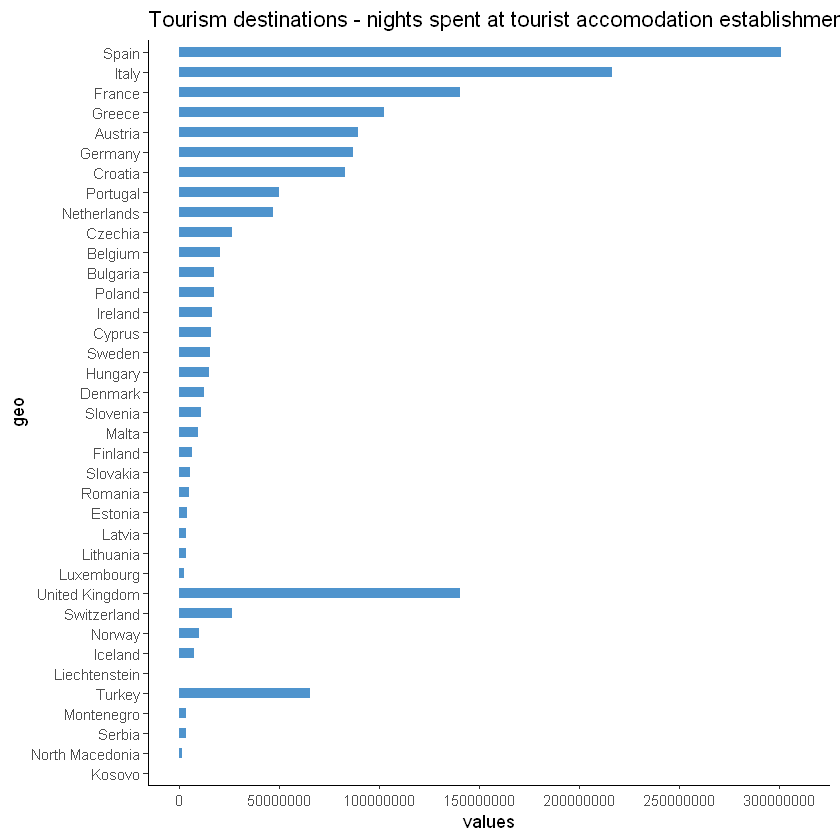

In [83]:
ggplot(data_mod4, aes(x=geo,y=values)) +
            geom_bar(stat = "identity", position="dodge", width=0.5, fill="steelblue3") +
            theme_classic() +
            scale_y_continuous(limits = c(0, 310000000), breaks = seq(0, 300000000, by = 50000000)) +
            ggtitle("Tourism destinations - nights spent at tourist accomodation establishments, 2018") +
            coord_flip() +
            scale_x_discrete(limits = rev(levels(data_mod4$geo)),
                             labels = c("Kosovo", "North Macedonia", "Serbia", "Montenegro", "Turkey", "Liechtenstein", 
                                        "Iceland", "Norway", "Switzerland", "United Kingdom", "Luxembourg", "Lithuania", 
                                        "Latvia", "Estonia", "Romania", "Slovakia", "Finland", "Malta", "Slovenia", 
                                        "Denmark", "Hungary", "Sweden", "Cyprus", "Ireland", "Poland", "Bulgaria", 
                                        "Belgium", "Czechia", "Netherlands", "Portugal", "Croatia", "Germany", "Austria", 
                                        "Greece", "France", "Italy", "Spain"))

In [ ]:
#to do
#Lücken zwischen EU-Ländern und Nicht-EU-Ländern in Graphiken